
**Tasks**

* Plot heatmap of population correlation matrix across **different area pairs using Allendata**. (remember to see the structure relation across areas)
* Plot the population correlation as the function of the **time delay between areas ($t_2$-$t_1$)**
  
   * remember to delete the head and tail of stimulus time when time delay
* Consider population correlation of **different stimulus periods**, such as "Early Evoked, 160ms after stimulus onset" and "Late Evoked, 1120ms after stimulus onset"
* Generalize feedforward (FF) canonical dimensions to feedback-dominated period

*population correlation*: Correlation value for the first canonical pair as a measure of inter-areal intercation strength

In [29]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import CCA

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

## Allen data preprocessing
Get AllenData sessions

In [30]:
basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

Select a session randomly

In [31]:
session_id = 799864342
session = cache.get_session_data(session_id)

print(session.structure_acronyms)
print(session.stimulus_names)

['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast']


Select 'drifting_gratings' stimuli with contrast 0.8 and temporal_frequency 15.0, but 8 different orientations. 
Each stimuli was presented 15 times for 2 seconds

In [32]:
stim_table = session.get_stimulus_table('drifting_gratings')
print(stim_table['temporal_frequency'].value_counts())

stim_orientation_table = stim_table[stim_table['temporal_frequency'] == 15.0 ]
print(stim_orientation_table['orientation'].value_counts())
print(stim_orientation_table['stimulus_condition_id'].value_counts())
stim_orientation_table.head()

15.0    120
8.0     120
4.0     120
2.0     120
1.0     120
null     30
Name: temporal_frequency, dtype: int64
270.0    15
45.0     15
315.0    15
90.0     15
135.0    15
180.0    15
225.0    15
0.0      15
Name: orientation, dtype: int64
254    15
252    15
248    15
247    15
277    15
272    15
267    15
256    15
Name: stimulus_condition_id, dtype: int64


,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3805,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1611.328291,2,drifting_gratings,1613.329971,15,2.00168,252
3807,0.8,90,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1617.333321,2,drifting_gratings,1619.334971,15,2.00165,254
3809,0.8,315,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1623.338331,2,drifting_gratings,1625.340001,15,2.00167,256


In [33]:
def spike_matrix(area, bin=0.1):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        bin -- _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, 2 + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_orientation_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    # convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
    # to stimulus_bins_counts * units,

    response_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1], response_matrix.shape[2])

    return response_matrix

(2400, 29)


Text(0, 0.5, 'spike counts')

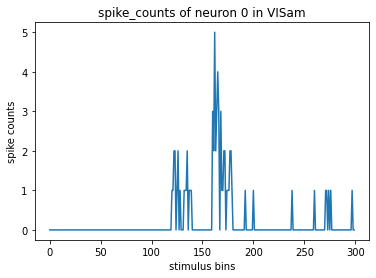

In [34]:
response_matrix_VISam = spike_matrix(area = 'VISam')

print(response_matrix_VISam.shape)

plt.figure()
plt.plot(response_matrix_VISam[:300, 0])
plt.title('spike_counts of neuron 0 in VISam')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

(2400, 44)


Text(0, 0.5, 'spike counts')

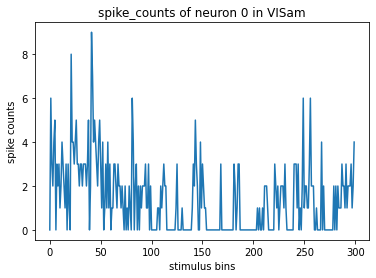

In [35]:
response_matrix_VISmma = spike_matrix(area = 'VISmma')

print(response_matrix_VISmma.shape)

plt.figure()
plt.plot(response_matrix_VISmma[:300, 0])
plt.title('spike_counts of neuron 0 in VISam')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

In [36]:
def corr_area_pairs(X_a, X_b, n_components = 3):
    """corr_area_pairs _summary_

    _extended_summary_

    Arguments:
        X_a -- _description_
        X_b -- _description_
    """

    # Standardize data to zero mean and unit variance
    X_a = (X_a - X_a.mean(axis=0)) / X_a.std(axis=0)
    X_b = (X_b - X_b.mean(axis=0)) / X_b.std(axis=0)

    cca = CCA(n_components)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) 

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b)

In [37]:
corr_VISam_VISmma, w_ab = corr_area_pairs(response_matrix_VISam, response_matrix_VISmma)

print(corr_VISam_VISmma)

[0.70580206 0.68787211 0.47318666]



**Task1**

* Plot heatmap of population correlation matrix across **different area pairs using Allendata**. (remember to see the structure relation across areas)

In [47]:
areas = session.structure_acronyms
print(len(areas))
print(areas)

# delete nan in areas
while np.nan in areas:
    areas.remove(np.nan)
print(len(areas))
print(areas)

# delete area with no units
for area in areas:
    units = session.units[session.units["ecephys_structure_acronym"] == area]
    if units.shape[0] == 0:
        areas.remove(area)
print(len(areas))
print(areas)

18
['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
17
['VISam', 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
16
['VISam', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']


In [64]:
areas_corr_matrix = np.empty([len(areas), len(areas)])

for i in range(len(areas)):
    for j in range(len(areas)):
        res_mat_i = spike_matrix(area = areas[i])
        res_mat_j = spike_matrix(area = areas[j])

        corr_ij, w = corr_area_pairs(res_mat_i, res_mat_j)
        areas_corr_matrix[i, j] = corr_ij[0]

print(areas_corr_matrix.shape)
# print(areas_corr_matrix)


(16, 16)


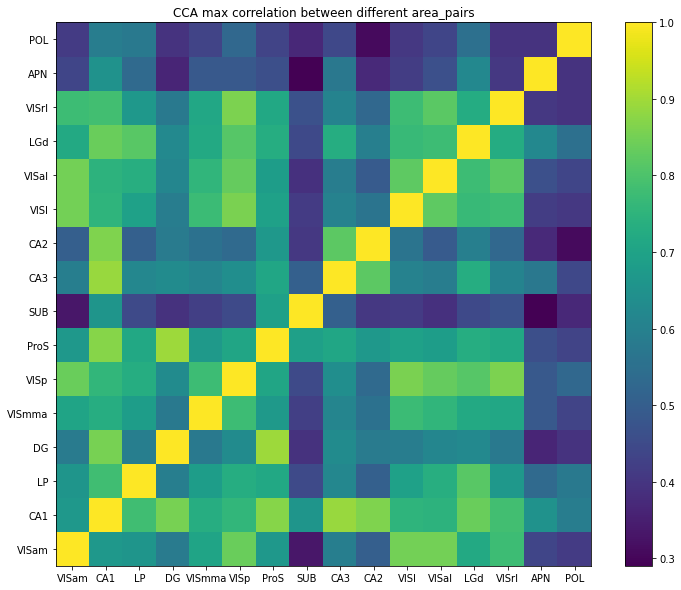

In [68]:
f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas))+np.array([0.5]))
ax.set_xticklabels(areas)
ax.set_yticks(range(len(areas))+np.array([0.5]))
ax.set_yticklabels(areas)
ax.set_title('CCA max correlation between different area_pairs')

f.colorbar(im)

plt.show()

**Results**

* After observe the correlation map, we can see that Visual cortex has more correlation with other areas
* SUB, APN, POL perform bad with other areas
* CA1, CA2 CA3 are correlated with each other more than others.

(16, 16)


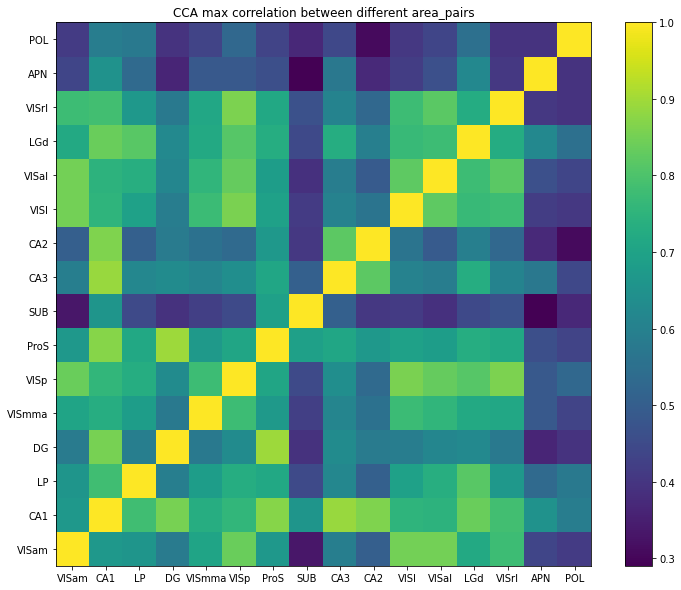

In [69]:
# Sort the areas after observation

areas_sorted = ['VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']

areas_corr_matrix = np.empty([len(areas), len(areas)])

for i in range(len(areas)):
    for j in range(len(areas)):
        res_mat_i = spike_matrix(area = areas[i])
        res_mat_j = spike_matrix(area = areas[j])

        corr_ij, w = corr_area_pairs(res_mat_i, res_mat_j)
        areas_corr_matrix[i, j] = corr_ij[0]

print(areas_corr_matrix.shape)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas))+np.array([0.5]))
ax.set_xticklabels(areas)
ax.set_yticks(range(len(areas))+np.array([0.5]))
ax.set_yticklabels(areas)
ax.set_title('CCA max correlation between different area_pairs after sorted')

f.colorbar(im)

plt.show()


**Task2**
* Plot the population correlation as the function of the **time delay between areas ($t_2$-$t_1$)**
  
   * remember to delete the head and tail of stimulus time when time delay

**Task3**
* Consider population correlation of **different stimulus periods**, such as "Early Evoked, 160ms after stimulus onset" and "Late Evoked, 1120ms after stimulus onset"


**Task4**
* Generalize feedforward (FF) canonical dimensions to feedback-dominated period